_본 노트북은 [텐서플로우 코리아 블로그](https://tensorflowkorea.wordpress.com)의 [First Contact with TensorFlow](http://www.jorditorres.org/TensorFlow/) 책의 [번역본](https://tensorflowkorea.wordpress.com/2016/04/28/first-contact-with-tensorflow/)을 코드를 직접 실행이 가능하도록 복사하여 옮긴 것입니다. 원본 및 번역본의 [라이센스 정책](https://creativecommons.org/licenses/by-nc-sa/3.0/)에 따라 공개 및 공유합니다._

2. 텐서플로우 선형 회귀분석
====

이 챕터에서 텐서플로우로 간단한 선형 회귀분석(Linear Regression) 모델을 만들어 보겠습니다. 예제를 통해서 기본적인 코드를 살펴보는 것과 동시에 코스트 함수(Cost function)와 그래디언트 디센트(Gradient Descent) 같은 머신러닝 학습에 있어서 중요한 콤포넌트들을 어떻게 사용하는지 알아보도록 하겠습니다.

변수간의 관계를 모델로
----

선형 회귀분석은 변수들 사이의 관계를 분석하는 데 사용하는 통계학적 방법입니다. 이 방법의 장점은 알고리즘의 개념이 복잡하지 않고 다양한 문제에 폭 넓게 적용할 수 있다는 것입니다. 이런 이유로 텐서플로우를 배우기 시작하는 데 선형 회귀분석의 예를 이용하는 것이 좋을 것 같습니다.

선형 회귀분석은 독립변수 x_i, 상수항 b(random term) 와 종속변수(역주: 결과 값, 즉 y) 사이의 관계를 모델화 하는 것으로 두 변수 사이의 관계일 경우 단순 회귀분석이라고 하며 여러개의 변수를 다루는 다중 회귀분석이 있습니다.

이번 장에서 텐서플로우가 어떻게 동작하는 지 설명하기 위해 y = W * x + b 형태의 간단한 선형 회귀분석 모델을 만들 것 입니다. 그러기 위해 이차원 좌표계에 데이터를 생성할 파이썬 프로그램을 만들고 이 샘플 데이터에 들어맞는 최적의 직선을 텐서플로우로 찾도록 하겠습니다.

첫번째 할 일은 좌표값들을 생성하기 위해 numpy 패키지를 임포트하는 것입니다. 코드는 아래와 같습니다.

In [1]:
import numpy as np

num_points = 1000
vectors_set = []
for i in xrange(num_points):
    x1= np.random.normal(0.0, 0.55)
    y1= x1 * 0.1 + 0.3 + np.random.normal(0.0, 0.03)
    vectors_set.append([x1, y1])

x_data = [v[0] for v in vectors_set]
y_data = [v[1] for v in vectors_set]

위 코드에서 볼 수 있듯이 y = 0.1 * x + 0.3 관계를 가지는 데이터를 생성했습니다. 하지만 정규분포(normal distribution)를 따라 약간의 편차를 두어 완전히 직선에 일치하지 않는 리얼리틱한 예를 만들었습니다.

이 그래프를 그리기 위해서는 다음 코드를 참고하세요.(그래프를 그리기 위해서는 matplotlib 패키지가 필요한데 pip install matplotlib 명령을 통해 설치할 수 있습니다)

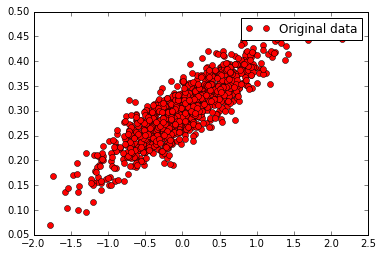

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x_data, y_data, 'ro', label='Original data')
plt.legend()
plt.show()

코스트 함수(Cost Function)와 그래디언트 디센트(Gradient Descent) 알고리즘
----

다음 단계는 입력 데이터 x_data로 부터 출력 값 y를 예측할 수 있는 학습 알고리즘을 훈련시키는 것입니다. 우리는 이미 이 모델이 선형회귀라는 것을 알고 있으므로 두개의 파라메타 W와 b로 모델을 표현할 수 있습니다.

입력데이터 x_data를 이용해 출력 데이터 y_data를 만들 수 있는 최적의 파라메타 W와 b를 찾도록 텐서플로우 코드를 만드는 것이 목적이며 이것은 y\_data = W * x\_data + b 와 같은 직선으로 나타납니다. 독자는 W가 0.1, b가 0.3에 근사한 값이어야 한다는 걸 알지만 텐서플로우는 모르고 있어 스스로 찾아내야 합니다.

이런 문제를 푸는 기본 방법은 데이터 셋의 값들을 반복하여 적용하면서 매번 더 정확한 결과를 얻기 위해 W와 b 파라메타를 수정하는 것 입니다. 반복이 일어날 때 마다 개선되고 있는지 확인하기 위해 얼마나 좋은 직선인지를 측정하는(사실은 나쁜 정도를 측정함) 코스트 함수(혹은 에러 함수)를 정의할 것 입니다.

이 함수는 W와 b를 파라메타로 받아 직선이 얼마나 데이터에 잘 맞는지를 기초로 하여 에러 값을 리턴합니다. 이 예제에서는 코스트 함수로 평균제곱오차(mean square error)를 사용합니다. 평균제곱오차는 실제 값과 알고리즘이 반복마다 추측한 값 사이의 거리를 에러로 하는 값의 평균입니다.

나중에 코스트 함수와 다른 방법에 대해서 조금 더 자세히 다루겠습니다만 여기서는 평균제곱오차를 이용해 예제를 차례대로 진행하는 것에 중점을 두겠습니다.

이제 설명했던 모든 것들을 텐서플로우를 사용해 프로그래밍할 시간입니다. 먼저 아래 코드처럼 세개의 변수를 만듭니다.

In [3]:
import tensorflow as tf

W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x_data + b

Variable 메소드를 호출하면 텐서플로우 내부의 그래프 데이터 구조에 만들어질 하나의 변수를 정의하게 된다고 이해합시다. 나중에 이 메소드의 파라메타에 대해 더 자세히 보도록 하겠습니다. 지금은 예제를 완성하기 위해 다음 단계로 넘어 가겠습니다.

이 변수들을 이용해서 앞서 이야기 했던대로 실제 값과 y = W * x + b 로 계산된 값 간의 거리를 기반으로 코스트 함수를 만듭니다. 그런 다음 제곱을 하고 모두 더하여 평균을 냅니다. 텐서플로우에서는 이 코스트 함수를 아래와 같이 나타냅니다.

In [4]:
loss = tf.reduce_mean(tf.square(y - y_data))

이 코드는 우리가 이미 알고 있는 값 y_data 와 입력 데이터 x_data로 계산된 y 값 사이의 거리를 제곱한 것의 평균을 계산합니다.

어쩌면 벌써 샘플 데이터에 가장 잘 맞는 직선은 작은 에러 값을 갖는 직선이라는 걸 눈치 챈 독자가 있을 지 모르겠습니다. 우리가 에러 함수를 최소화하면 데이터에 가장 최적의 모델을 얻은 것 입니다.

너무 자세히 들어가지 않겠지만 이것이 함수 값을 최소화하는 최적화 알고리즘인 그래디언트 디센트가 하는 역할입니다. 이론적으로 보면 그래디언트 디센트는 일련의 파라메타로 된 함수가 주어지면 초기 시작점에서 함수의 값이 최소화 되는 방향으로 파라메타를 변경하는 것을 반복적으로 수행하는 알고리즘입니다. 함수의 기울기가 음의 방향인 쪽으로 진행하면서 반복적으로 최적화를 수행합니다. 보통 양의 값을 만들기 위해 거리 값을 제곱하는 것이고 기울기를 계산해야 하므로 에러 함수는 미분 가능해야 합니다.

알고리즘은 파라메타(W와 b)의 초기 값에서 시작해서 위 방법으로 W와 b를 수정해가며 결국에는 에러 함수를 최소화하는 변수 값을 얻을 수 있습니다.

이 알고리즘을 텐서플로우에서 사용하기 위해서는 아래 두 문장을 실행해야 합니다.

In [5]:
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

이제 텐서플로우가 내부 데이터 구조에 관련 데이터를 생성한다는 것을 알아 보았고 코스트함수를 등록하여 그래디언트 디센트 알고리즘 옵티마이저(optimizer) train을 구현했습니다. 나중에 학습 속도(learning rate) 파라메타에 대해 이야기 하겠습니다.(여기서는 0.5로 지정했습니다)

알고리즘 실행
----

여기까지는 텐서플로우 라이브러리를 호출하는 코드는 단지 내부 그래프 구조에 정보를 추가시킨 것일 뿐 텐서플로우의 실행 모듈은 아직 아무런 알고리즘도 실행하지 않았습니다. 그러므로 이전 챕터에서와 같이 session을 생성하고 run 메소드를 train 파라메타와 함께 호출해야 합니다.  또한 변수를 선언했으므로 아래와 같은 명령으로 초기화해야 합니다.

In [6]:
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

이제 입력 데이터에 최적화 된 직선의 W와 b를 찾기 위해 반복적인 프로세스를 실행합니다. 훈련 과정은 목표 정확도에 다다를 때까지 계속됩니다. 이 예에서는 8번의 반복이면 충분할 것 같다고 생각하여 아래와 같이 쓸 수 있습니다.

In [7]:
for step in xrange(8):
    sess.run(train)
print sess.run(W), sess.run(b)

[ 0.14094792] [ 0.29899678]


그리고 그래프로 결과를 보고 싶다면 아래 코드를 참고하세요.

/Users/jamie/usr/virenv/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


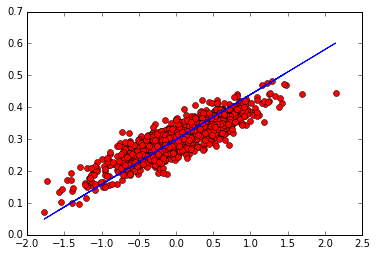

In [8]:
plt.plot(x_data, y_data, 'ro')
plt.plot(x_data, sess.run(W) * x_data + sess.run(b))
plt.legend()
plt.show()

8번의 반복으로 얻은 W = 0.0854, b = 0.299 인 직선을 그래프에서 볼 수 있습니다.

간한하게 설명하기 위해 8번만 반복 했었는데 더 진행한다면 좀 더 원래 값과 가까운 파라메타를 얻을 수 있습니다. 아래 문장으로 W와 b를 출력해 봅니다.(역주: 별다른 언급이 없지만 아래 문장은 for 문 안에 작성해야합니다)

In [9]:
with tf.Session() as sess:
    sess.run(init)
    for step in xrange(8):
        sess.run(train)
        print step, sess.run(W), sess.run(b)

0 [-0.20377642] [ 0.30165049]
1 [-0.10992215] [ 0.30091909]
2 [-0.04521943] [ 0.30042329]
3 [-0.00061372] [ 0.30008149]
4 [ 0.03013722] [ 0.29984587]
5 [ 0.05133676] [ 0.29968342]
6 [ 0.06595161] [ 0.29957142]
7 [ 0.07602701] [ 0.29949424]


알고리즘이 초기 값은 W=-0.0484, b=0.2972 로 시작해서 코스트 함수를 최소화하도록 파라메타를 조정해 갔음을 관찰할 수 있습니다.

아래 코드로 코스트 함수가 감소하는 것을 확인할 수 있습니다.

In [10]:
with tf.Session() as sess:
    sess.run(init)
    for step in xrange(8):
        sess.run(train)
        print(step, sess.run(loss))

(0, 0.0033919797)
(1, 0.0020884464)
(2, 0.0014689231)
(3, 0.0011744851)
(4, 0.0010345487)
(5, 0.00096804189)
(6, 0.00093643344)
(7, 0.00092141115)


알고리즘이 어떻게 파라메타를 조정하는 지 눈으로 확인하려면 매 반복마다 그래프를 그려보는 것이 좋습니다. 8번의 스냅샷 이미지는 아래와 같습니다.

(0, array([ 0.57398868], dtype=float32), array([ 0.29569048], dtype=float32), 0.071169101)


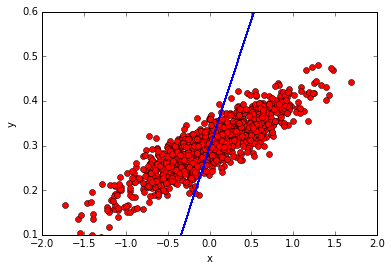

(1, array([ 0.42626503], dtype=float32), array([ 0.29681048], dtype=float32), 0.034300536)


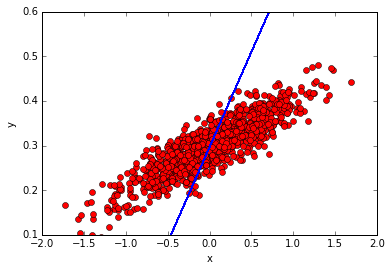

(2, array([ 0.32442522], dtype=float32), array([ 0.29759085], dtype=float32), 0.016778214)


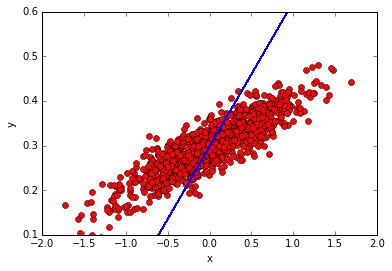

(3, array([ 0.25421736], dtype=float32), array([ 0.29812881], dtype=float32), 0.008450455)


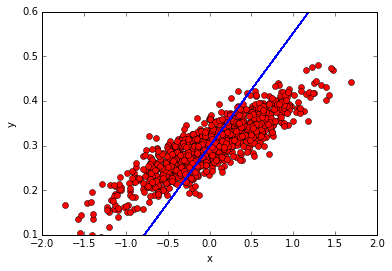

(4, array([ 0.20581645], dtype=float32), array([ 0.2984997], dtype=float32), 0.0044925641)


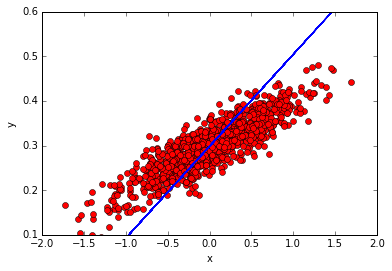

(5, array([ 0.1724491], dtype=float32), array([ 0.29875538], dtype=float32), 0.002611516)


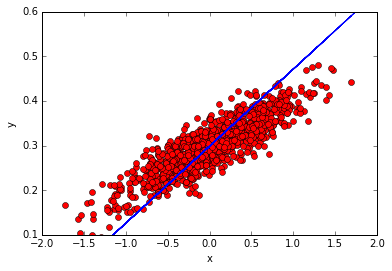

(6, array([ 0.14944583], dtype=float32), array([ 0.29893166], dtype=float32), 0.0017175199)


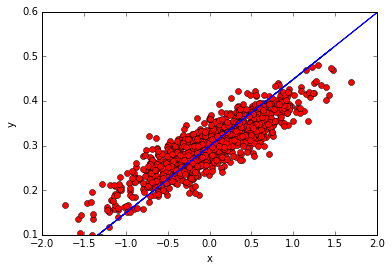

(7, array([ 0.13358749], dtype=float32), array([ 0.29905316], dtype=float32), 0.0012926345)


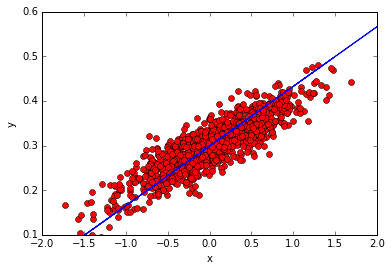

In [11]:
with tf.Session() as sess:
    sess.run(init)
    for step in range(8):
        sess.run(train)
        print(step, sess.run(W), sess.run(b), sess.run(loss))
        # 산포도 그리기
        plt.plot(x_data, y_data, 'ro')
        # 직선 그리기
        plt.plot(x_data, sess.run(W) * x_data + sess.run(b))
        # x, y 축 레이블링을 하고 각 축의 최대, 최소값 범위를 지정합니다.
        plt.xlabel('x')
        plt.xlim(-2,2)
        plt.ylim(0.1,0.6)
        plt.ylabel('y')
        plt.show()

눈으로 확인할 수 있듯이 알고리즘은 반복하면서 점차 데이터에 더 적합한 직선을 만듭니다. 어떻게 그래디언트 디센트 알고리즘은 코스트 함수를 최소화하는 파라메타를 찾아가는 걸까요?

예제의 에러 함수로 두개의 파라메타(W 와 b)로 구성되어 있어서 우리는 2차원 공간에 표현할 수 있습니다.(역주: W와 b를 x, y로 하는 2차원 좌표계를 생각하면 됩니다) 이 2차원 공간의 각 점은 하나의 직선을 나타냅니다.(역주: 한쌍의 W와 b는 한 직선을 나타내므로) 각 점에서 에러 함수의 높이는 직선에 대한 에러입니다.(역주: W, b 그리고 에러 함수를 x, y, z 로 하는 3차원 좌표계를 생각하면 됩니다) 어떤 직선들은 다른 직선보다 더 작은 에러를 가집니다. 텐서플로우가 그래디언트 디센트 알고리즘을 수행할 때 이 평면의 한 지점(W=-0.04841119, b=0.29720169)에서 시작하여 더 작은 에러를 갖는 직선을 찾아 이동합니다.

그래디언트 디센트 알고리즘을 수행하기 위해 텐서플로우는 이 에러 함수의 기울기를 계산합니다. 기울기는 나침판 같은 역할을 하게 되어 에러가 낮은 곳의 방향을 가르킵니다. 기울기를 계산하기 위해 텐서플로우는 에러 함수를 미분합니다. 이 예제에서는 반복이 일어날 때마다 움직일 방향을 알아내기 위해 W와 b에 대해 편미분 방정식 계산이 필요합니다.

이전에 언급한 학습 속도는 텐서플로우가 각 반복 때마다 얼마나 크게 이동할 것인가를 제어합니다. 학습속도를 너무 크게 하면 최소값을 지나쳐 버릴 수 있습니다. 하지만 학습속도를 너무 작게 하면 최소값에 다다르는데 많은 반복(역주: 즉 오랜 시간)이 필요하게 됩니다. 그러므로 적절한 학습속도를 선택하는 것이 중요합니다. 학습속도를 적응시킬 수 있는 여러 테크닉들이 있지만 이 입문서의 범위를 벗어 납니다. 그래디언트 디센트 알고리즘이 제대로 작동하는 지 확인하는 좋은 방법은 매 반복 마다 에러가 줄어드는지를 보는 것 입니다.

이 장의 코드를 테스트 하려면 이 책의 깃허브 레파지토리에서 regression.py 파일을 다운 받을 수 있습니다. 한 눈에 보기 쉽게 아래에 코드를 합쳐 놓았습니다.(역주: 파이썬 3  notebook으로 작성한 이 섹션의 코드는 여기에서 보실 수 있습니다.)

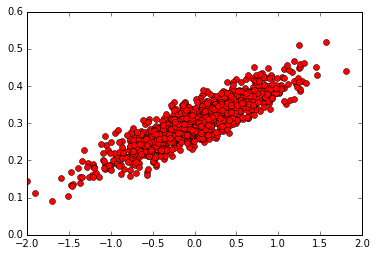

(0, array([-0.29293078], dtype=float32), array([ 0.30024368], dtype=float32))
(0, 0.049854133)


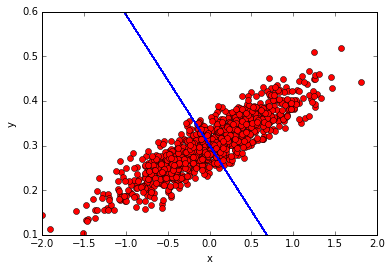

(1, array([-0.16819276], dtype=float32), array([ 0.30067024], dtype=float32))
(1, 0.023675133)


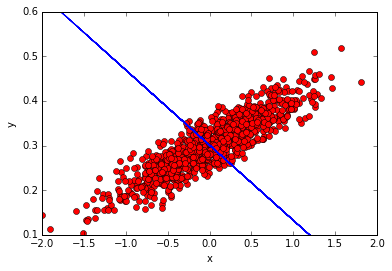

(2, array([-0.08306146], dtype=float32), array([ 0.30096304], dtype=float32))
(2, 0.011481484)


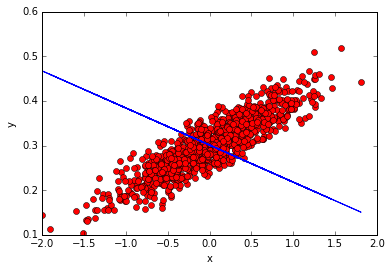

(3, array([-0.02496098], dtype=float32), array([ 0.3011629], dtype=float32))
(3, 0.0058019217)


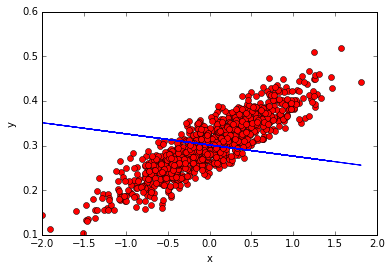

(4, array([ 0.01469149], dtype=float32), array([ 0.3012993], dtype=float32))
(4, 0.0031564946)


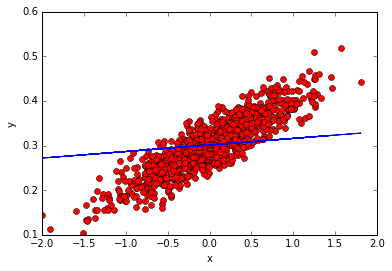

(5, array([ 0.04175355], dtype=float32), array([ 0.30139238], dtype=float32))
(5, 0.0019243071)


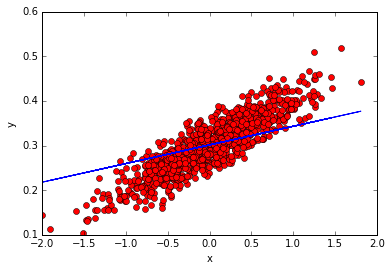

(6, array([ 0.06022289], dtype=float32), array([ 0.30145591], dtype=float32))
(6, 0.0013503783)


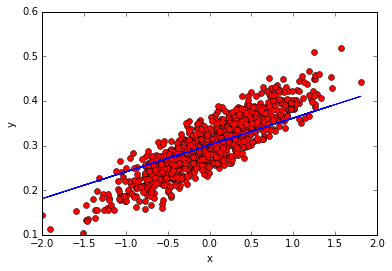

(7, array([ 0.07282785], dtype=float32), array([ 0.30149928], dtype=float32))
(7, 0.0010830541)


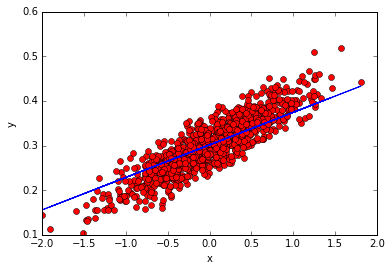

In [12]:
import numpy as np

num_points = 1000
vectors_set = []
for i in xrange(num_points):
    x1= np.random.normal(0.0, 0.55)
    y1= x1 * 0.1 + 0.3 + np.random.normal(0.0, 0.03)
    vectors_set.append([x1, y1])

x_data = [v[0] for v in vectors_set]
y_data = [v[1] for v in vectors_set]

import matplotlib.pyplot as plt

#Graphic display
plt.plot(x_data, y_data, 'ro')
plt.legend()
plt.show()

import tensorflow as tf

W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x_data + b

loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

for step in xrange(8):
    sess.run(train)
    print(step, sess.run(W), sess.run(b))
    print(step, sess.run(loss))

    #Graphic display
    plt.plot(x_data, y_data, 'ro')
    plt.plot(x_data, sess.run(W) * x_data + sess.run(b))
    plt.xlabel('x')
    plt.xlim(-2,2)
    plt.ylim(0.1,0.6)
    plt.ylabel('y')
    plt.legend()
    plt.show()

이 장에서 우리는 기본적인 선형 회귀분석 알고리즘을 사용해서 두개의 필수적인 요소, 코스트 함수와 그래디언트 디센트 알고리즘을 직관적인 방법으로 설명하는 것으로 텐서플로우 패키지 탐험을 시작했습니다. 다음 장에서는 텐서플로우에서 사용하는 데이터 구조에 대해 자세히 다루겠습니다.